# Financial Machine Learning - Bars

最近在啃Marcos Lopez de Prado的 Advances in Financial Machine Learning，感觉很有难度，我想通过笔记的形式将自己的理解慢慢记录下来。总体讲这本书给我很多的启发。个人感觉，网上很多所谓machine learning在finance和investment上的应用都是谬误的，其实这本书并不会讨论具体的算法，而更多的是提供一种machine learning在finance 应用上的标准流程或者说是方法论，懂得了这些流程/方法论并不能保证你就能写出赚钱的模型来，但是，可以帮助你避免很多错误和陷阱，从而节约了你很多的时间。本书的观点认为，ML在投资领域的应用犹如一种工业化的生产过程，在当今市场的有效性条件下，企图靠某个个人所谓的深厚功力写出一个盈利可观的模型变得越来越不切实际了，只有依靠大量的人力，标准化的流程才可能在高度有效的市场环境下生存。

该书首先从数据准备讲起。他的观点是，如果某项数据所有人都在用，那这个数据的价值就不大了。比如财报数据，当然，传统bar（K线）数据的价值也不大，一方面人人都在用，另外一方k线数据的采样是有缺陷的。举例来说，假如我们使用5分钟线，那么通常在每天开盘和收盘的时间段成交比较密集，也就意味着这段时间包含的信息量比较多。但是，传统的k线只做定期采样，造成的结果就是，各个5分钟k线包含的信息量是不等的，导致很多的信息量无法被体现出来。为了避免这样的缺陷，该书提出了以下几种bar：

- Tick Bars

- Volume Bars

- Dollar Bars

- Imbalance Bars

接下来我以沪深300指数的1分钟k线为基础，分别来看这些Bar有什么区别。

## Time Bars

Time bars就是指最常见的k线了。原始数据是1分钟k线，我可以将其合成为15分钟k线





In [2]:
# load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

data = pd.read_csv("C:\\Nutstore\\我的坚果云\\investment\\practice\\quant\\data\\hs300.csv")
# change column name
data.rename(columns={data.columns[0]:"timestamp"}, inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
# data['timestamp'] = data.timestamp.map(lambda t: datetime.strptime(t, "%Y-%m-%d %H:%M:%S"))

def compute_vwap(df):
    # 因为groupby有upsampling的问题，所以，必须剔出这些额外增加出来的非交易时段的ts
    if df.isna().to_numpy().any():
        return
    q = df['volume']
    p = df['close'] # use close price
    vwap = np.sum(p * q) / np.sum(q)
    df['vwap'] = vwap
    # print(df.head())
    return df

data_timeidx = data.set_index('timestamp')


In [3]:
sub_data = data_timeidx['2015-05']
data_time_grp = sub_data.groupby(pd.Grouper(freq='15Min', closed='right'))
# num_time_bars = len(data_time_grp) # comes in handy later
num_time_bars = 1
group_name_list = list()
for name, group in data_time_grp:
    if group.empty == False:
        num_time_bars += 1
        group_name_list.append(name)

data_time_vwap = data_time_grp.apply(compute_vwap)    

In [4]:
# data_time_vwap.head()
# data_resampled = data_timeidx.resample('15Min')
# data_time_vwap[100:130]
# data_time_grp.first()
# data_time_vwap['2015-04-17']['vwap'].plot()
# data_time_vwap['2015-04-17']['vwap'][115:200].plot()
# data_time_vwap['2015-05-04':'2015-05-29'].head(16)


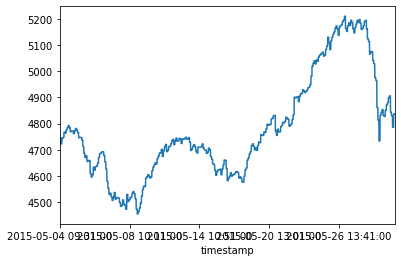

In [5]:
# draw the time bar
# data_time_vwap['2015']['vwap'].plot()
# data_time_vwap['2015-05']
sub_df = data_time_vwap.copy()
sub_df.index = sub_df.index.map(str)
sub_df['vwap'].plot()
# pos_2015_05_b = test_df.index.get_loc('2015-05-04 09:31:00')
# pos_2015_05_e = test_df.index.get_loc('2015-05-29 15:00:00')
# test_df.iloc[pos_2015_05_b:pos_2015_05_e+1]['vwap'].plot()
# test_df.iloc[pos_2015_05_b:pos_2015_05_e+1].tail()
# test_df.iloc[116:117]

# d1 = data_resample['close'].mean()[7:100]
# d1.head()

## Tick Bars

为了避免上述Time bar的问题，一种方法是构建tick bar。 所谓tick bar是以某个固定的tick数量来切分并生成对应的bar，例如：每个tick bar包含50个tick。这样做的好显而易见，就是当市场的某些时段交易很活跃的时候，就有更多的tick bar生成出来即更多的采样，反之，生成的tick bar的数量减少。因此，相较于传统的time bar，每个tick bar包含的信息更加均衡。

但是tick bar也有一个缺点，例如：一个tick对应10手买单，和10个tick，每个tick分别对应1手买单。但是，他们包含的信息量显然不一样，简单来说，前者可能是掌握了某些信息的市场参与者的行为，而后者可能更多的是一种随机行为。按照tick bar的生成方式，前者就无法被及时采样，并容易被其他低信息量的tick淹没。

由于我或的原始数据是1分钟k线而非tick数据，因此无法合成tick bar。

## Volume Bars

所谓的volume bar就是以某个固定的成交量来切分并生成对应的bar。例如：每个bar包含10000股的成交量。这样就改进了tick bar存在的问题，使得每个volume bar所含的信息量更为平均

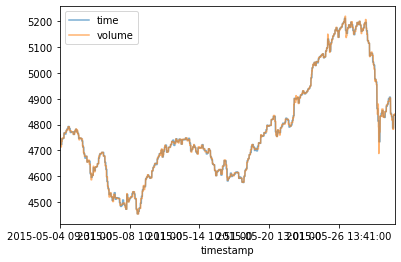

In [9]:
data_cm_vol = sub_data.assign(cmVol=sub_data['volume'].cumsum()) 
total_vol = data_cm_vol.cmVol.values[-1]
vol_per_bar = total_vol / num_time_bars
vol_per_bar = round(vol_per_bar, 0) 
data_vol_grp = data_cm_vol.assign(grpId=lambda row: row.cmVol // vol_per_bar)
data_vol_vwap =  data_vol_grp.groupby('grpId').apply(compute_vwap)
# plot
sub_df1 = data_vol_vwap.copy()
sub_df1.index = sub_df1.index.map(str)
# data_vol_vwap.set_index('timestamp', inplace=True)
# data_vol_vwap.head(20)
plot_data = {'time': sub_df['vwap'], 'volume':sub_df1['vwap']}
plot_df = pd.DataFrame(plot_data)
plot_df.plot(alpha=0.6)

由上图可见volume bar在一些波峰和波谷的位置更加的显著，说明在偏极端的行情的环境下，volume bar保存的信息更多。

## Dollar Bars

同Volume bar类似，所谓的Dollar bar就是以某个固定的成交金额来切分并生成对应的bar。例如：每个bar包含100000元。一个比较直观想法是：当上证综合指数在6000点买入100手股票同在1000点买入100手股票是完全不同的概念，由于在资金量上的巨大的差异，虽然手数相同，但是这两个决定所包含的信息应该是差异很大。

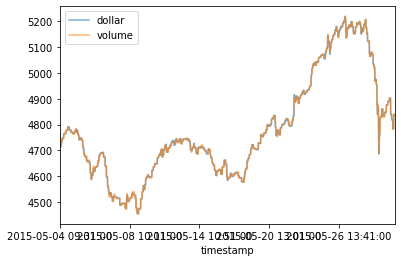

In [10]:
data_cm_dollar = sub_data.assign(cmDollar=sub_data['total_turnover'].cumsum()) 
total_dollar = data_cm_dollar.cmDollar.values[-1]
dollar_per_bar = total_dollar / num_time_bars
dollar_per_bar = round(dollar_per_bar, 0) 
data_dollar_grp = data_cm_dollar.assign(grpId=lambda row: row.cmDollar // dollar_per_bar)
data_dollar_vwap =  data_dollar_grp.groupby('grpId').apply(compute_vwap)
# plot
sub_df2 = data_dollar_vwap.copy()
sub_df2.index = sub_df2.index.map(str)

plot_data = {'dollar': sub_df2['vwap'], 'volume':sub_df1['vwap']}
plot_df = pd.DataFrame(plot_data)
plot_df.plot(alpha=0.6)

In [ ]:
上图是dollar bar 和 volume bar的比较。区别不是很大。可以看出，在一些比较极端的走势图形上，dollar bar和volume bar的采样还是有一定区别。

除了以上这些bar外，还有一种bar叫做Imbalance bar，由于相对比较复杂，所以会单独开一篇来介绍。